In [27]:
# Import Library
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision.models import resnet18

In [28]:
# Transform Data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [29]:
# Load CIFAR10 Dataset 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.6116571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7305385].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.757044].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8183348].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.757044].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71

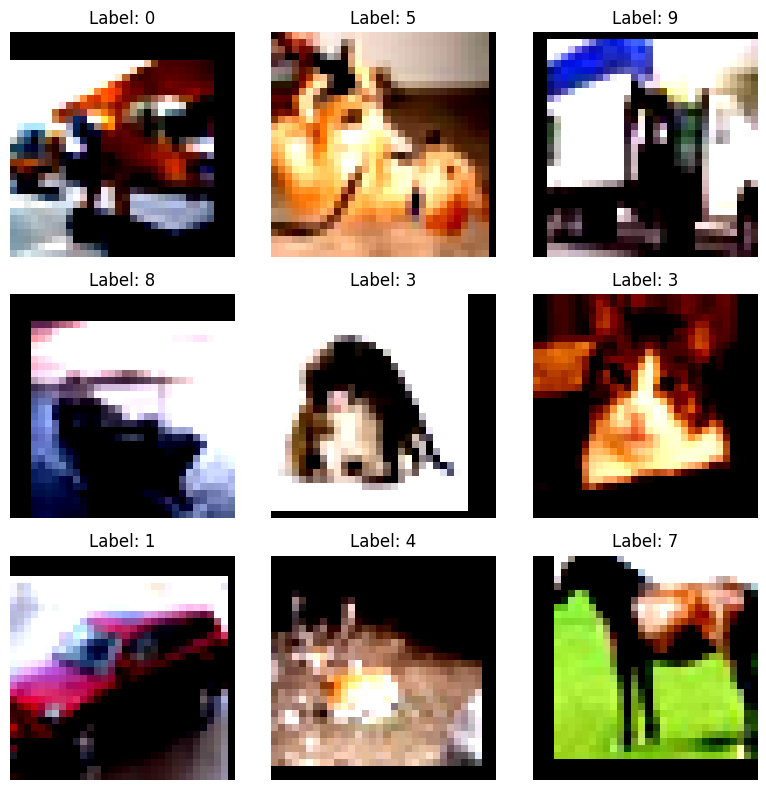

In [30]:
# Pick 9 Random Image from Trainset
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

dataiter = iter(trainloader)
images, labels = next(dataiter)

images = images[:9]
labels = labels[:9]

fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    img = imshow(images[i])
    ax.imshow(img)
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [31]:
# AlexNet Model
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.resnet = resnet18(pretrained=False)  # Menggunakan ResNet-18
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # Menyesuaikan output layer

    def forward(self, x):
        return self.resnet(x)

In [32]:
# Model, Loss Function, and Optimizer Initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [34]:
# Training
def train(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass dan optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(targets).sum().item()
        total_samples += targets.size(0)

    train_loss = running_loss / len(trainloader)
    train_acc = total_correct / total_samples
    return train_loss, train_acc

In [35]:
# Testing
def test(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Statistik
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_correct += predicted.eq(targets).sum().item()
            total_samples += targets.size(0)

    test_loss = running_loss / len(testloader)
    test_acc = total_correct / total_samples
    return test_loss, test_acc

In [36]:
# Array for Plotting
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [37]:
# Train and Test Dataset
num_epochs = 30

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
    test_loss, test_acc = test(model, testloader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch 1/30
Train Loss: 1.5403, Train Accuracy: 0.4375
Test Loss: 1.2158, Test Accuracy: 0.5634
Epoch 2/30
Train Loss: 1.1773, Train Accuracy: 0.5772
Test Loss: 1.0271, Test Accuracy: 0.6390
Epoch 3/30
Train Loss: 1.0209, Train Accuracy: 0.6383
Test Loss: 1.0699, Test Accuracy: 0.6368
Epoch 4/30
Train Loss: 0.9229, Train Accuracy: 0.6757
Test Loss: 0.9620, Test Accuracy: 0.6681
Epoch 5/30
Train Loss: 0.8388, Train Accuracy: 0.7048
Test Loss: 0.8270, Test Accuracy: 0.7098
Epoch 6/30
Train Loss: 0.7835, Train Accuracy: 0.7257
Test Loss: 0.7560, Test Accuracy: 0.7352
Epoch 7/30
Train Loss: 0.7312, Train Accuracy: 0.7462
Test Loss: 0.7682, Test Accuracy: 0.7377
Epoch 8/30
Train Loss: 0.6903, Train Accuracy: 0.7602
Test Loss: 0.7168, Test Accuracy: 0.7583
Epoch 9/30
Train Loss: 0.6642, Train Accuracy: 0.7686
Test Loss: 0.6833, Test Accuracy: 0.7636
Epoch 10/30
Train Loss: 0.6317, Train Accuracy: 0.7790
Test Loss: 0.6833, Test Accuracy: 0.7639
Epoch 11/30
Train Loss: 0.6087, Train Accuracy: 0

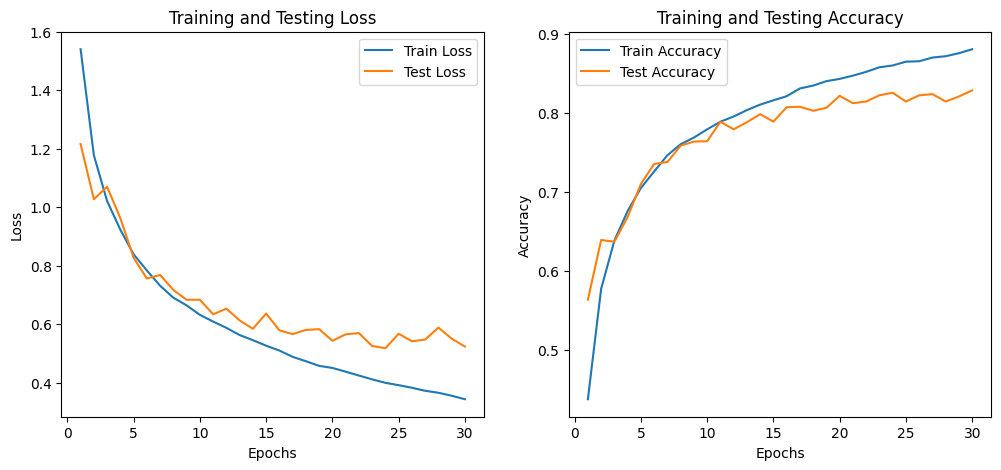

In [39]:
# Loss and Accuracy Plot

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.show()